In [1]:
import os
import numpy as np
import pandas as pd
from entsoe import EntsoePandasClient


In [2]:

os.environ["559550e1-666a-4ed4-ae3f-1f157021bc9f"] = "559550e1-666a-4ed4-ae3f-1f157021bc9f"

token = os.environ["559550e1-666a-4ed4-ae3f-1f157021bc9f"]
client = EntsoePandasClient(api_key=token)

# Bidding zone for Germany-Luxembourg (Germany focus)
zone = "DE_LU"


In [3]:
# Date range: last ~3 years to today
end = pd.Timestamp.now(tz="Europe/Brussels").normalize() + pd.Timedelta(hours=12)
start = end - pd.DateOffset(years=3)

# Fetch hourly prices (EUR/MWh)
prices_hourly = client.query_day_ahead_prices(zone, start=start, end=end)

# Convert to Europe/Berlin for convenience
prices_hourly = prices_hourly.tz_convert("Europe/Berlin").sort_index()



prices_hourly


2022-08-16 12:00:00+02:00    417.08
2022-08-16 13:00:00+02:00    410.06
2022-08-16 14:00:00+02:00    410.09
2022-08-16 15:00:00+02:00    418.06
2022-08-16 16:00:00+02:00    442.53
                              ...  
2025-08-16 08:00:00+02:00     80.99
2025-08-16 09:00:00+02:00     67.94
2025-08-16 10:00:00+02:00     25.12
2025-08-16 11:00:00+02:00      3.80
2025-08-16 12:00:00+02:00      0.17
Freq: 60min, Length: 26305, dtype: float64

In [4]:
# Daily mean prices in EUR/MWh
prices_daily = prices_hourly.resample('D').mean().dropna()

# Daily returns: percentage change
returns = prices_daily.pct_change().dropna()

prices_daily.head(), returns.head()


(2022-08-16 00:00:00+02:00    522.781667
 2022-08-17 00:00:00+02:00    551.952500
 2022-08-18 00:00:00+02:00    563.760000
 2022-08-19 00:00:00+02:00    515.097083
 2022-08-20 00:00:00+02:00    457.973750
 Freq: D, dtype: float64,
 2022-08-17 00:00:00+02:00    0.055799
 2022-08-18 00:00:00+02:00    0.021392
 2022-08-19 00:00:00+02:00   -0.086318
 2022-08-20 00:00:00+02:00   -0.110898
 2022-08-21 00:00:00+02:00   -0.204906
 Freq: D, dtype: float64)

In [5]:
alpha = 0.99          # 99% confidence
position_mwh = 1.0    # exposure (change this if you like)

last_price = float(prices_daily.iloc[-1])

# Historical P&L distribution for a long position
pnl_hist = position_mwh * last_price * returns.values  # vector of daily P&L in EUR

# VaR: positive number representing a loss threshold
var_hist = -np.quantile(pnl_hist, 1 - alpha)
var_hist = max(var_hist, 0.0)

# ES (Expected Shortfall): average loss beyond VaR, also as a positive number
tail_mask = pnl_hist <= -var_hist
es_hist = -np.mean(pnl_hist[tail_mask]) if np.any(tail_mask) else var_hist
es_hist = max(es_hist, 0.0)

print(f"Germany (DE-LU) — Historical (1-day, {position_mwh:.0f} MWh)")
print(f"  99% VaR: {var_hist:,.2f} EUR")
print(f"  99% ES : {es_hist:,.2f} EUR")


Germany (DE-LU) — Historical (1-day, 1 MWh)
  99% VaR: 59.29 EUR
  99% ES : 197.50 EUR


In [6]:
n_sim = 100000
np.random.seed(42)

# Sample daily returns with replacement
sampled_returns = np.random.choice(returns, size=n_sim, replace=True)

# Simulated P&L
pnl_mc = position_mwh * last_price * sampled_returns

# Monte Carlo VaR
var_mc = -np.quantile(pnl_mc, 1 - alpha)

# Monte Carlo ES
es_mc = -pnl_mc[pnl_mc <= -var_mc].mean()

print(f"99% Monte Carlo VaR (1-day, 1 MWh): {var_mc:.2f} EUR")
print(f"99% Monte Carlo ES  (1-day, 1 MWh): {es_mc:.2f} EUR")


99% Monte Carlo VaR (1-day, 1 MWh): 59.15 EUR
99% Monte Carlo ES  (1-day, 1 MWh): 198.74 EUR


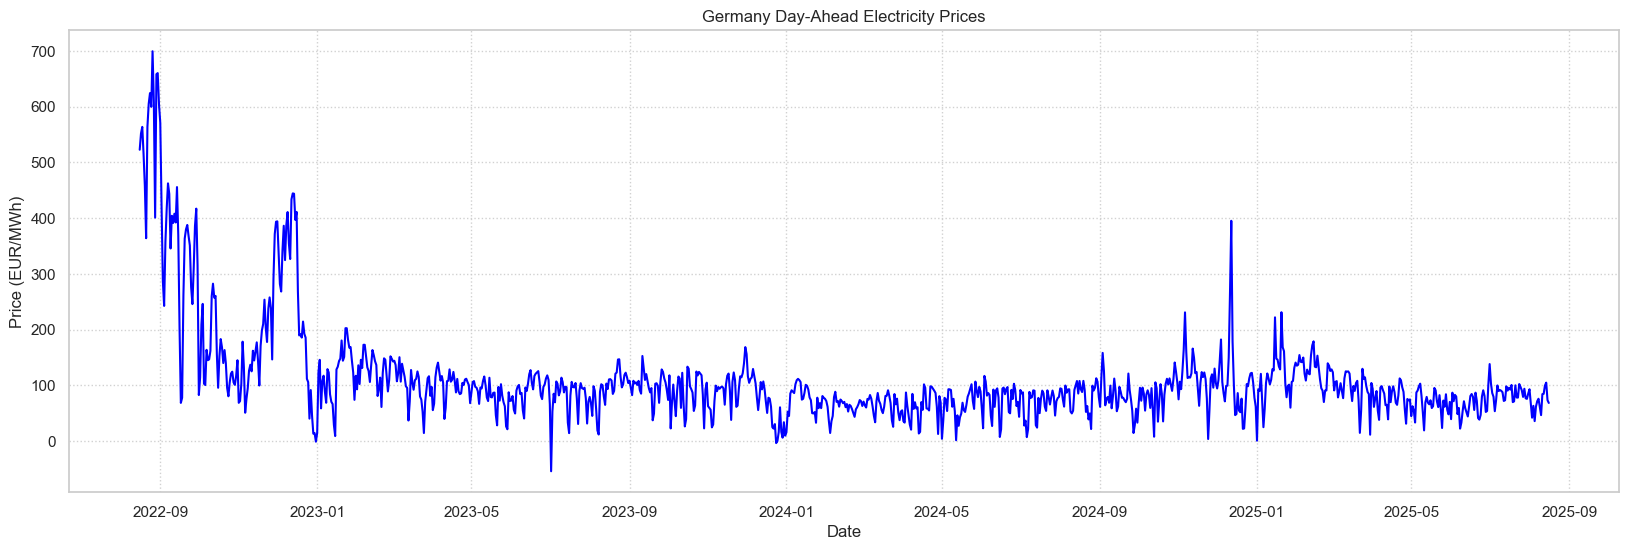

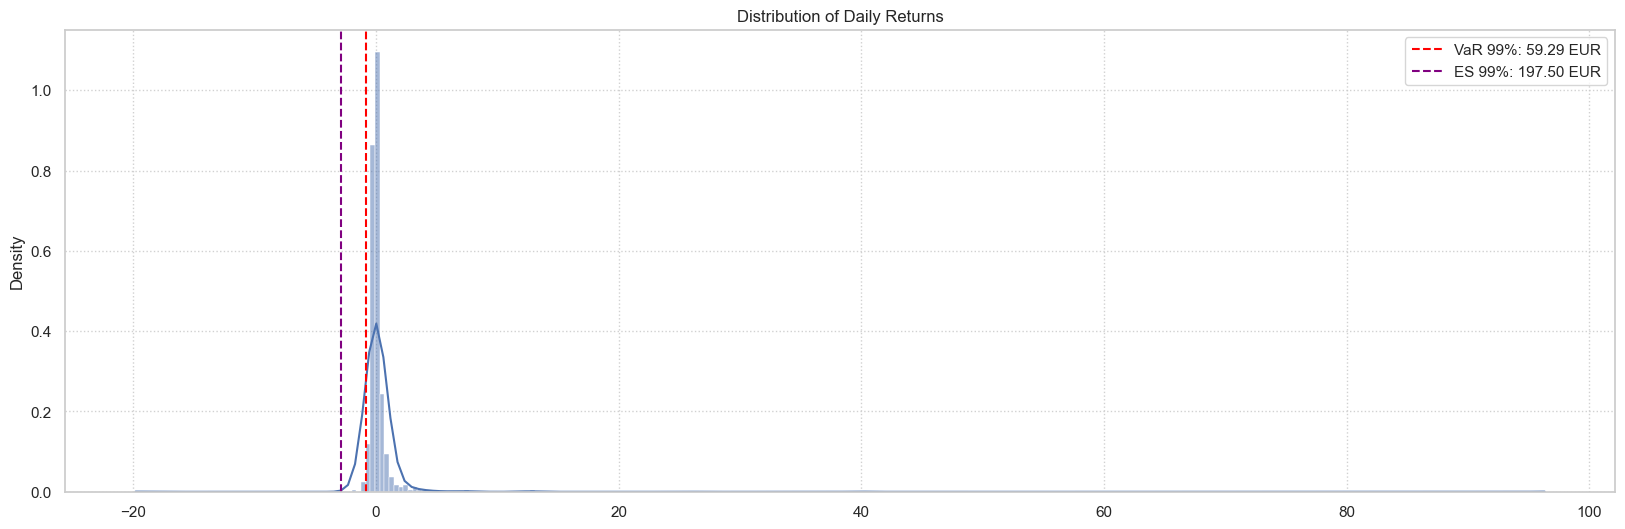

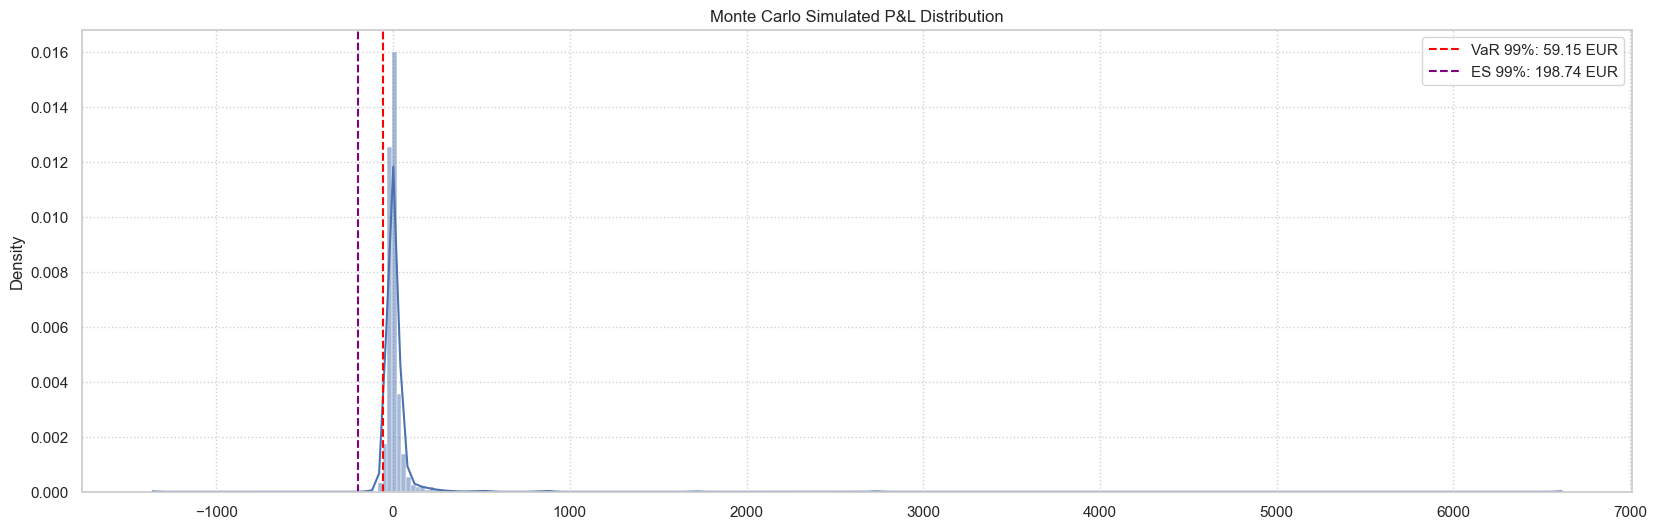

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

# Historical Prices
plt.figure(figsize=(20,6))
sns.lineplot(x=prices_daily.index, y=prices_daily.values, color='blue')
plt.title('Germany Day-Ahead Electricity Prices')
plt.xlabel('Date')
plt.ylabel('Price (EUR/MWh)')
plt.grid(linestyle=':', alpha=0.9)
plt.show()

# Returns Distribution
plt.figure(figsize=(20,6))
sns.histplot(returns, bins=300, kde=True, stat='density')
plt.axvline(-var_hist / last_price, color='red', linestyle='--', label=f'VaR 99%: {var_hist:.2f} EUR')
plt.axvline(-es_hist / last_price, color='purple', linestyle='--', label=f'ES 99%: {es_hist:.2f} EUR')
plt.title('Distribution of Daily Returns')
plt.legend()
plt.grid(linestyle=':', alpha=0.9)
plt.show()

# Monte Carlo P&L
plt.figure(figsize=(20,6))
sns.histplot(pnl_mc, bins=300, kde=True, stat='density')
plt.axvline(-var_mc, color='red', linestyle='--', label=f'VaR 99%: {var_mc:.2f} EUR')
plt.axvline(-es_mc, color='purple', linestyle='--', label=f'ES 99%: {es_mc:.2f} EUR')
plt.title('Monte Carlo Simulated P&L Distribution')
plt.legend()
plt.grid(linestyle=':', alpha=0.9)
plt.show()



In [8]:


# Results Presentation
print("\n" + "="*60)
print(f"GERMANY (DE-LU) ELECTRICITY PRICE RISK ASSESSMENT")
print(f"Analysis Period: {start.date()} to {end.date()}")
print(f"Last Price: {last_price:.2f} EUR/MWh")
print("="*60 + "\n")

print("1-DAY RISK METRICS (1 MWh POSITION)")
print("-"*50)
print(f"{'Historical VaR (99%):':<25}{var_hist:>15,.2f} EUR")
print(f"{'Historical ES (99%):':<25}{es_hist:>15,.2f} EUR")
print(f"{'Monte Carlo VaR (99%):':<25}{var_mc:>15,.2f} EUR")
print(f"{'Monte Carlo ES (99%):':<25}{es_mc:>15,.2f} EUR")
print("\n" + "="*60)


GERMANY (DE-LU) ELECTRICITY PRICE RISK ASSESSMENT
Analysis Period: 2022-08-16 to 2025-08-16
Last Price: 68.64 EUR/MWh

1-DAY RISK METRICS (1 MWh POSITION)
--------------------------------------------------
Historical VaR (99%):              59.29 EUR
Historical ES (99%):              197.50 EUR
Monte Carlo VaR (99%):             59.15 EUR
Monte Carlo ES (99%):             198.74 EUR

